In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score,precision_score, recall_score, f1_score,mean_absolute_error, mean_squared_error,precision_recall_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from xgboost import cv

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#load & view the data
df = pd.read_csv('output/pec_prep_out.csv')
df=df.drop([ "Unnamed: 0"], axis=1)

In [3]:
df.shape

(1097, 40)

In [4]:
df.head()

,Compagnie d'assurance,Date de création,Nom et Prénom Assuré /Raison Sociale,Immatriculation Véhicule assuré,Mode de gestion,Garantie impliquée,Chargé réparation,Marque,Réparateur,Expert,Compagnie adverse,Accord VR (Véhicule de remplacement),Agence,Agent,Cas de barème,Chargé acceptation,Code agence,Date Accident,Date acceptation,Date accord (SST),Date demande,Etape Dossier,Etat d'approbation,Immatriculation tiers,Montant total devis,Nom et Prénom tiers /Raison Sociale,Numero sinistre,Numéro de contrat,Point Choc,Position GA,SST,Nbr réclamations antérieures,Jour Accident,Mois Accident,Année Accident,Jour demande,Mois demande,Année demande,Retard reclamation,Fraud
0,EL AMANA TAKAFUL,43664,NACEUR HBIBI,9594TU195,IDA,Défense et recours,Asma TURKI,ISUZU,MECATOL,Hadiji Yassine,MAE,NON,global assurance,global assurance,10.0,Ouni Hela,744,03/31/2019,04/04/2019 11:15,10/04/2019 13:22,04/04/2019,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),5178TU196,914.604,STE ATELIER GHRAPHIQUE,S19/9165,2015.5.0088637/3,"Tiers Ar. D,Tiers Lat. D",Recours,Fathi Nguili,2,31,3,2019,4,4,2019,4,Non
1,LA CARTE,16/12/2019,STE HOTEL BYZANCE,6657TU193,Dommages,Dommages au véhicule,,ALFA ROMEO,NaN,NaN,ASSURANCES STAR,NaN,mohamed boussaa,mohamed boussaa,9.0,Ouni Hela,780,12/04/2019,26/12/2019 17:23,NaN,12/09/2019,En instance d'établissement Devis,Approuvé ( Chef cellule Acceptation ),9332TU62,NaN,EL GHOUL AHMED BEN AMOR,S1955133140,201950000046682,Tiers Ar. D,Recours,,1,4,12,2019,9,12,2019,5,Non
2,LLOYD TUNISIEN,43475.0,MOUNA BEJAOUI,6130TU156,Dommages,Tierce collision,Asma TURKI,KIA,SPEED SERVICES,Salah BEN HASSINE,BIAT assurances,NON,sondos ayoub,sondos ayoub,15.0,Ouni Hela,658,05/21/2019,28/05/2019 12:40,11/06/2019 13:06,05/24/2019,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),1984TU124,1790.491,IMMOBILIERE GRAND ATLAS,S19551114002,201850000077730,Tiers Lat. D,Recours,Tayssir HMAIED,1,21,5,2019,24,5,2019,3,Non
3,LLOYD TUNISIEN,43518.0,SOUHAIELA RIGHI,341TU196,Dommages,Tierce collision,Ouni Dhekra,VOLKSWAGEN,Société EL-FATAH,Hadiji Yassine,LLOYD TUNISIEN,NON,wajih laamiri,wajih laamiri,NaN,Ouni Hela,776,03/30/2019,05/04/2019 17:39,20/05/2019 14:35,04/05/2019,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),NaN,2468.064,NaN,S19551109400,201650000091405,Tiers Ar. D,Défense,Fathi Nguili,1,30,3,2019,5,4,2019,6,Non
4,LLOYD TUNISIEN,43521.0,AHMED BRAHAM,7445TU172,Dommages,Tierce collision,Ouni Dhekra,VOLKSWAGEN,Société EL-FATAH,Amara Ayari,GAT assurances,OUI,aisaoui fathi,aisaoui fathi,10.0,Ouni Hela,685,04/07/2019,16/04/2019 17:35,22/04/2019 12:55,04/15/2019,Véhicule réparé: en instance de Signature du BS,Approuvé ( Chef cellule Acceptation ),6214TU68,2972.116,ALI JOUILI,S1955109776,201850000041652,Tiers Av. G,Recours,Fathi Nguili,1,7,4,2019,15,4,2019,8,Non


In [5]:
# dropping uninformative features
colsToDelete = ['Année demande','Année Accident','Nom et Prénom Assuré /Raison Sociale',
       'Immatriculation Véhicule assuré','Nom et Prénom tiers /Raison Sociale','Immatriculation tiers', 
       'Numero sinistre', 'Numéro de contrat','Date de création','Date Accident','Date acceptation','Date accord (SST)' ,'Date demande']
df = df.drop(columns = colsToDelete, axis=1)


In [6]:
df.shape

(1097, 27)

In [7]:
threshold = 0.97
# calculate correlations
corr_matrix = df.corr().abs()
# get the upper part of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# columns with correlation above threshold
redundent = [column for column in upper.columns if any(upper[column] >= threshold)]
print(f'Columns to drop with correlation > {threshold}: {redundent}')
df.drop(columns=redundent, inplace=True)

Columns to drop with correlation > 0.97: ['Mois demande']


In [8]:
y = df["Fraud"].map({"Non":0, "Oui":1})
X = df.drop("Fraud", axis=1)

In [9]:
le = LabelEncoder()
for i in  (X.columns):  
    le.fit(X[i].astype(str))
    X[i] = le.transform(X[i].astype(str))

In [10]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [11]:
# train test split data
testsize=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testsize, random_state=0)

In [12]:
params = { }
          
# instantiate the classifier 
model = XGBClassifier(objective='binary:logistic',learning_rate=0.1, max_depth=3,
                      colsample_bytree=1, n_estimators=100,subsample=1,booster='gbtree')

# fit the classifier to the training data
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.5f' % mean(scores))

Mean ROC AUC: 0.71629


In [14]:
# make predictions on test data
y_pred = model.predict(X_test)

In [15]:
for metric in [accuracy_score,precision_score,recall_score,f1_score,mean_absolute_error,mean_squared_error]:
            print(f'{metric.__name__}: {round(metric(y_test, y_pred), 4)}')

accuracy_score: 0.7818
precision_score: 0.25
recall_score: 0.0455
f1_score: 0.0769
mean_absolute_error: 0.2182
mean_squared_error: 0.2182


In [16]:
kfold = KFold(n_splits=10, random_state=7)
accuracy = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
roc_auc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

print('Cross-validation Accuracy score: ', round(accuracy.mean(),4))
print('Cross-validation AUC score: ', round(roc_auc.mean(),4)) 

Cross-validation Accuracy score:  0.8003
Cross-validation AUC score:  0.7106


In [17]:
confusion_matrix(y_test, y_pred)

array([[170,   6],
       [ 42,   2]])

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
preds = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, preds)
conf_mat

array([[841,  41],
       [190,  25]])

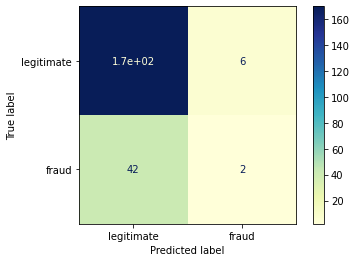

In [19]:
class_names=['legitimate', 'fraud']
plot_confusion_matrix(model, X_test, y_test,display_labels=class_names,cmap="YlGnBu")
plt.savefig('figure_EDA/confMatXGB.png',dpi=400,bbox_inches='tight')
plt.show()

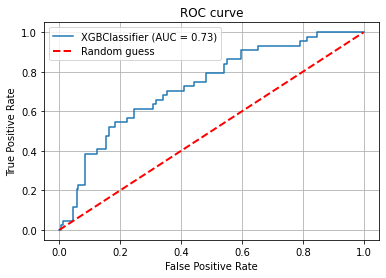

In [21]:
metrics.plot_roc_curve(model, X_test, y_test) 
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.legend()
plt.savefig('figure_EDA/rocXGB.png',dpi=400,bbox_inches='tight')
plt.show() 

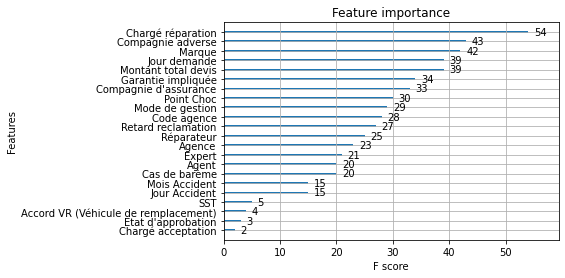

In [22]:
xgb.plot_importance(model)
plt.rcParams['figure.figsize'] = [12, 8]
plt.savefig('figure_EDA/plot_importance.png',dpi=400,bbox_inches='tight')
plt.show()

In [23]:
from sklearn.externals import joblib
joblib.dump(model, 'model/xgb_model.pkl')

['model/xgb_model.pkl']

In [24]:
model_columns= list(X.columns)
print(model_columns)
joblib.dump(model_columns, 'model/model_columns.pkl')

["Compagnie d'assurance", 'Mode de gestion', 'Garantie impliquée', 'Chargé réparation', 'Marque', 'Réparateur', 'Expert', 'Compagnie adverse', 'Accord VR (Véhicule de remplacement)', 'Agence', 'Agent', 'Cas de barème', 'Chargé acceptation', 'Code agence', 'Etape Dossier', "Etat d'approbation", 'Montant total devis', 'Point Choc', 'Position GA', 'SST', 'Nbr réclamations antérieures', 'Jour Accident', 'Mois Accident', 'Jour demande', 'Retard reclamation']


['model/model_columns.pkl']

In [25]:
import model_evaluation_utils as meu

meu.display_model_performance_metrics(y_test, y_pred, classes=[0,1])


Model Performance metrics:
------------------------------
Accuracy: 0.7818
Precision: 0.6915
Recall: 0.7818
F1 Score: 0.7164

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.80      0.97      0.88       176
           1       0.25      0.05      0.08        44

    accuracy                           0.78       220
   macro avg       0.53      0.51      0.48       220
weighted avg       0.69      0.78      0.72       220


Prediction Confusion Matrix:
------------------------------
          Predicted:   
                   0  1
Actual: 0        170  6
        1         42  2


In [26]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(model, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
conf_mat

array([[841,  41],
       [190,  25]])